<a href="https://colab.research.google.com/github/giuliovv/ANNDL_competitions/blob/master/2_RNN/toma_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to drive and import libraries

In [2]:
import os

colab = "True" #@param ['True','False']
if colab == "True":
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/Colab Notebooks

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np

tfk = tf.keras
tfkl = tf.keras.layers

### Data inspection

In [4]:
plt.rcParams["figure.figsize"] = (20,10)
data = pd.read_csv("Training.csv")
data.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
Sponginess,1.000000,0.253002,0.297509,0.121744,0.331200,0.127885,0.183141
Wonder level,0.253002,1.000000,0.119078,0.930254,0.367438,0.237021,0.074392
Crunchiness,0.297509,0.119078,1.000000,0.067477,0.029108,0.061539,0.987209
Loudness on impact,0.121744,0.930254,0.067477,1.000000,0.056184,0.229336,0.048806
Meme creativity,0.331200,0.367438,0.029108,0.056184,1.000000,0.078168,-0.040596
Soap slipperiness,0.127885,0.237021,0.061539,0.229336,0.078168,1.000000,0.050996
Hype root,0.183141,0.074392,0.987209,0.048806,-0.040596,0.050996,1.000000


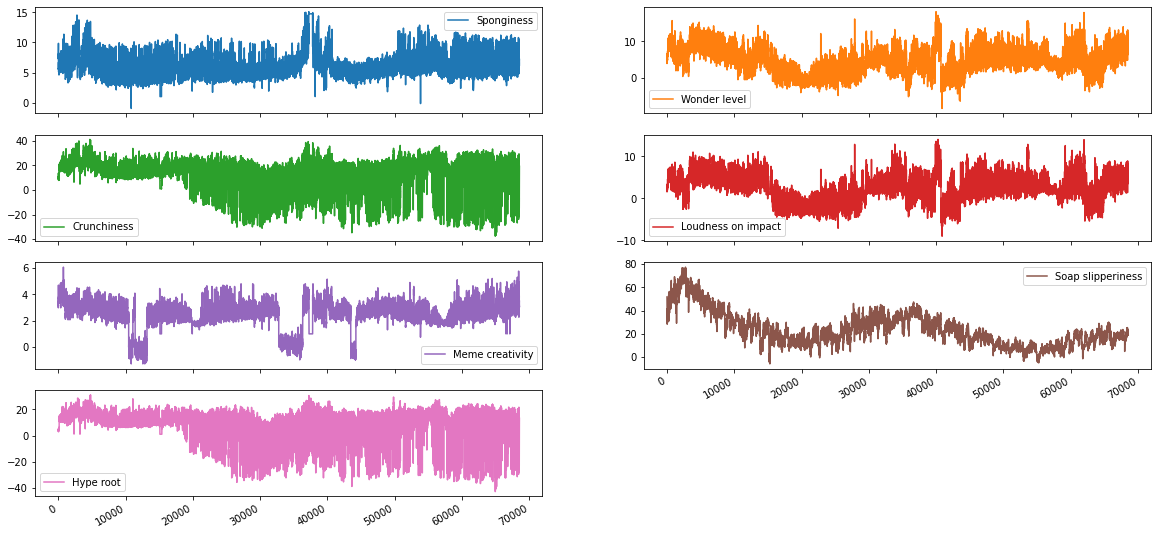

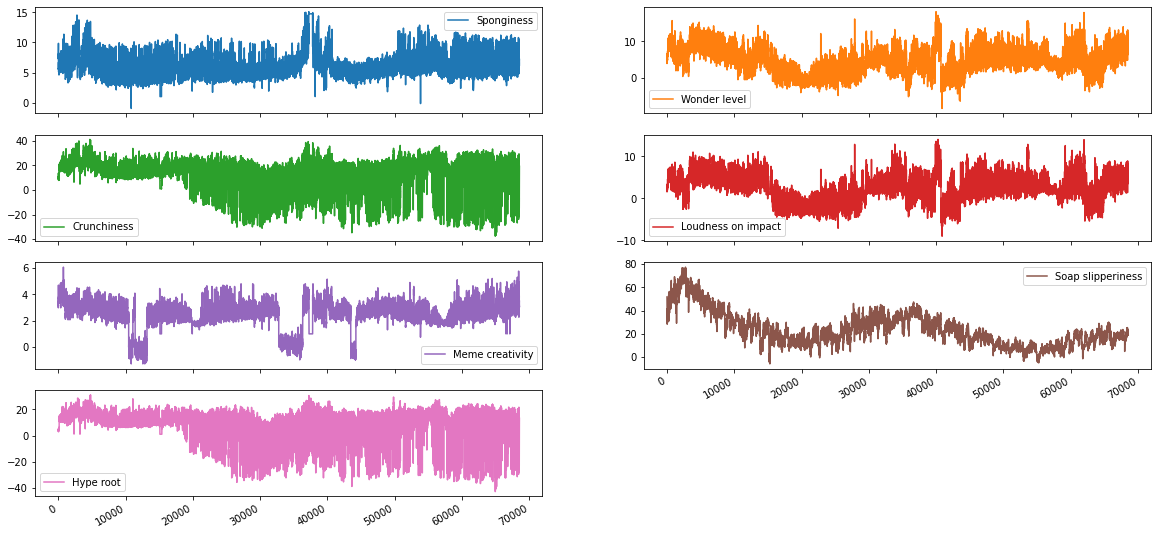

In [5]:
data.plot(subplots=True, layout=(4,2))
data.plot(subplots=True, layout=(4,2))
data.corr().style.background_gradient(cmap='coolwarm')


### Set seed for reproducibility

In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Creating training and testing data

(61676, 7) (6852, 7)


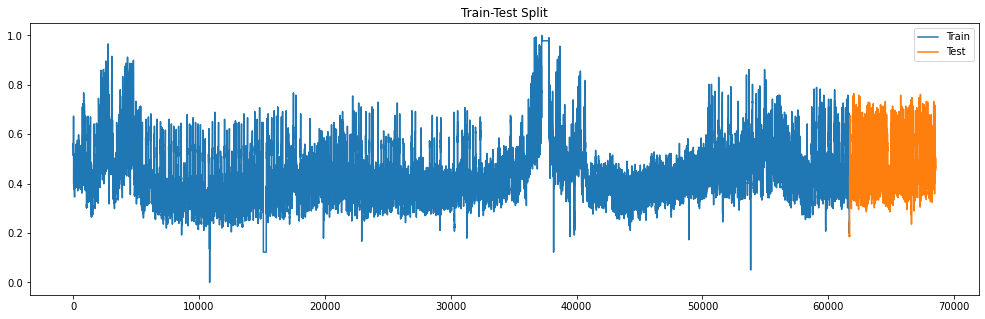

In [16]:
TEST_SPLIT = 0.1

test_size = int(len(data)*TEST_SPLIT)
X_train_raw = data.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = data.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train')
plt.plot(X_test_raw['Sponginess'], label='Test')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [17]:
window = 200
stride = 10

In [18]:
future = data[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 200, 7)

In [19]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [21]:
target_labels = data.columns
telescope = 100

In [22]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6150, 200, 7), (6150, 100, 7), (670, 200, 7), (670, 100, 7))

In [23]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

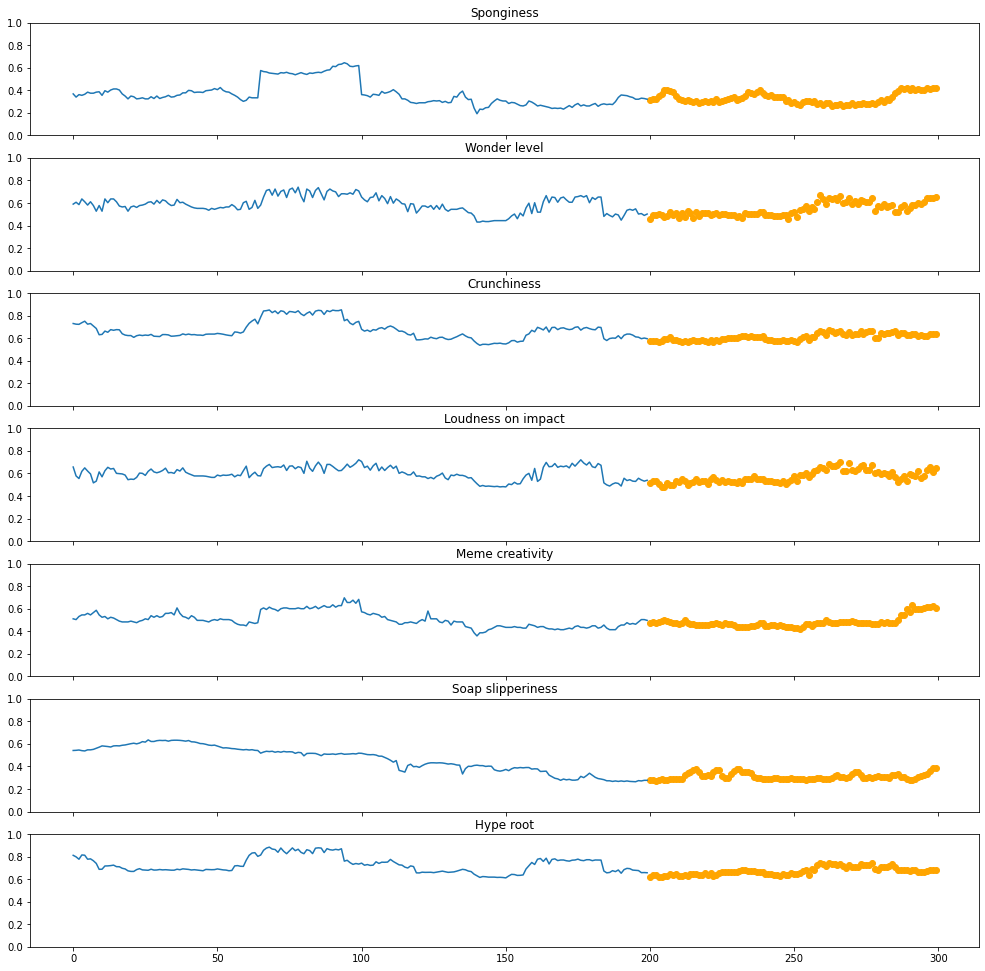

In [24]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [25]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

### Building network

In [29]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         36864     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 200, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 128)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         263168    
 nal)                                                            
                                                             

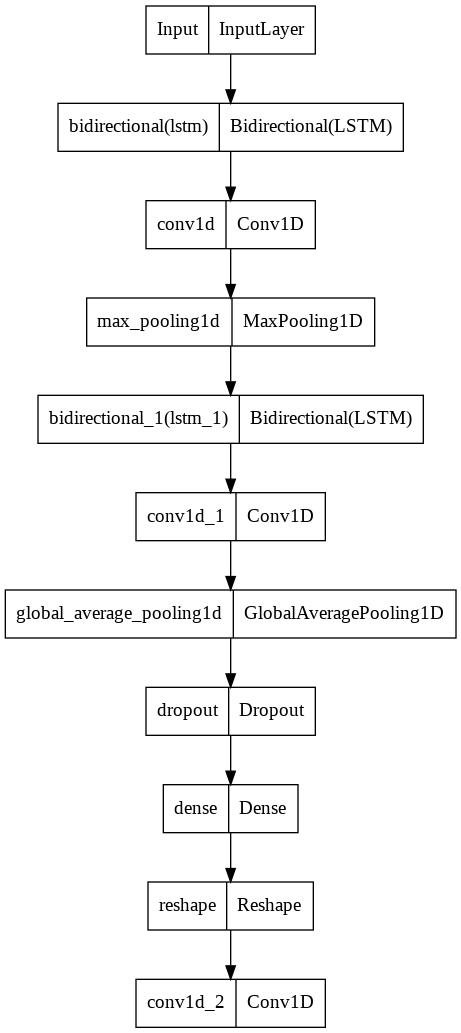

In [30]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tf.keras.utils.plot_model(model, expand_nested=True)

In [31]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
25/87 [=======>......................] - ETA: 57s - loss: 0.1426 - mae: 0.3096

KeyboardInterrupt: ignored